# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import numpy as np
import pandas as pd
from IPython.display import Image

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, Input, Masking, LSTM, Embedding, Dense
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm_notebook as tqdm
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/MyDrive/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

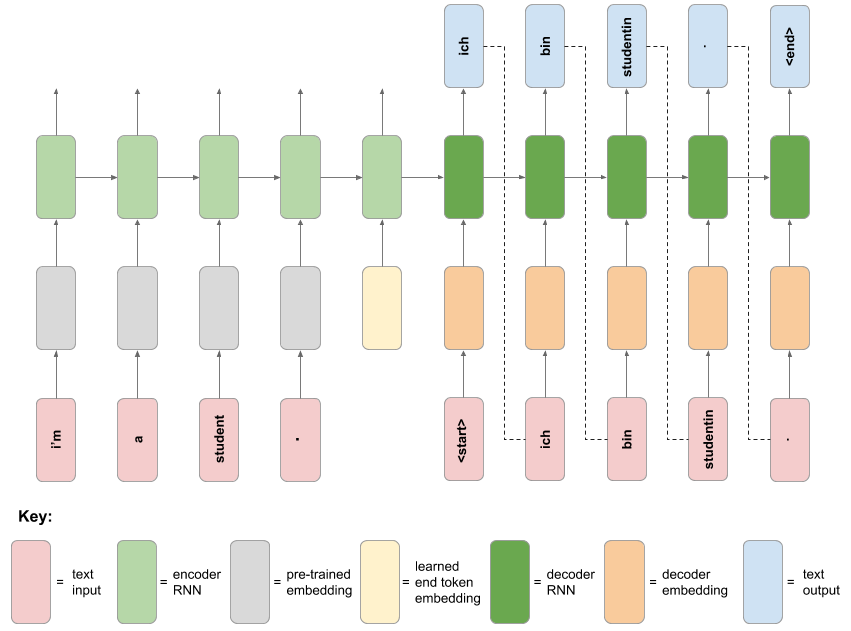

In [ ]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing

In [ ]:
english_sent = [sentence.split('\t')[0] for sentence in data_examples]
german_sent = [sentence.split('\t')[1] for sentence in data_examples]
processed_english = []
processed_german = []
for sentence in english_sent:
    processed_english.append(preprocess_sentence(sentence))
for sentence in german_sent:
    processed_german.append(preprocess_sentence(sentence))

In [ ]:
p_german_1 = ["<start> "+ sentence + " <end>" for sentence in processed_german]

In [ ]:
tokenizer = Tokenizer(filters = '')

tokenizer.fit_on_texts(p_german_1)
tokenizer_seq = tokenizer.texts_to_sequences(p_german_1)

In [ ]:
num_of_sentences = len(p_german_1)

random_ind = np.random.choice(num_of_sentences,5)
print('German Sentences :')
for ind in random_ind:
    print(p_german_1[ind])
print()
print('Token sequences :')
for ind in random_ind:
    print(tokenizer_seq[ind])
print()
print('English Sentences :')
for ind in random_ind:
    print(processed_english[ind])

German Sentences :
<start> was haben sie gesagt ? <end>
<start> tom ist ein nichtsnutz . <end>
<start> tom braucht hilfe . <end>
<start> tom ist gerissen . <end>
<start> sie ist mein typ . <end>

Token sequences :
[1, 38, 35, 8, 178, 7, 2]
[1, 5, 6, 19, 1513, 3, 2]
[1, 5, 197, 283, 3, 2]
[1, 5, 6, 3713, 3, 2]
[1, 8, 6, 50, 772, 3, 2]

English Sentences :
what did you say ?
tom is useless .
tom needs help .
tom is crafty .
she's my type .


In [ ]:
padded_seq = pad_sequences(tokenizer_seq,maxlen = None,padding = "post")

## 2. Prepare the data

#### Load the embedding layer

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In [ ]:
# split data
x_train,x_valid,y_train,y_valid = train_test_split(processed_english,padded_seq,test_size = 0.20)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [ ]:
def spliter(english,german):
 
  english = tf.strings.split(english,sep = " ")

  return english,german

train_dataset = train_dataset.map(spliter)
valid_dataset = valid_dataset.map(spliter)

In [ ]:
def embedder(english,german):

  english = embedding_layer(english)
  return english,german

train_dataset = train_dataset.map(embedder)
valid_dataset = valid_dataset.map(embedder)

In [ ]:
def lengther(english,german):
  length = tf.constant(13,dtype = tf.int32)

  return tf.math.greater_equal(length,tf.cast(len(english),tf.int32))

train_dataset = train_dataset.filter(lengther)
valid_dataset = valid_dataset.filter(lengther)

In [ ]:
def padder(english,german):

  paddings = [[13-len(english),0],[0,0]]
  english = tf.pad(english, paddings = paddings)

  return english,german

train_dataset = train_dataset.map(padder)
valid_dataset = valid_dataset.map(padder)

In [ ]:
train_dataset = train_dataset.batch(16,drop_remainder= True)
valid_dataset = valid_dataset.batch(16,drop_remainder= True)

In [ ]:
print("Training Dataset: ")
print(train_dataset.element_spec)
print("Validation Dataset: ")
print(valid_dataset.element_spec)

Training Dataset: 
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))
Validation Dataset: 
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

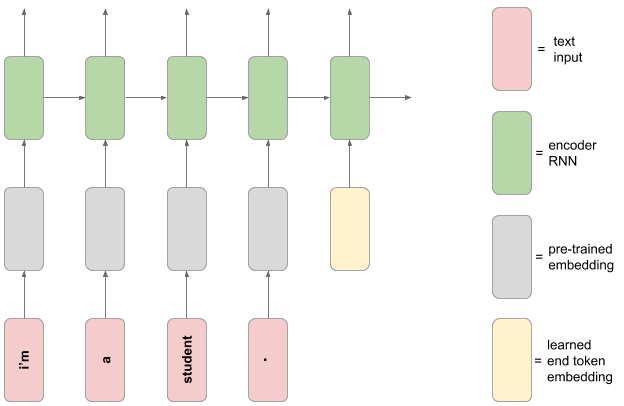

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

In [ ]:
class EndTokenLayer(Layer):
  
  def __init__(self, embedding_dim=128, **kwargs):
    super(EndTokenLayer, self).__init__(**kwargs)
    self.embedding_dim = embedding_dim
  def build(self, input_shape):
    self.end_token_emb = self.add_weight(shape=(input_shape[-1],),
                                          initializer='random_uniform',
                                         trainable= True)
  def call(self, inputs):
    end_token = tf.tile(tf.reshape(self.end_token_emb, shape=(1, 1, self.end_token_emb.shape[0])), [tf.shape(inputs)[0],1,1])
    return tf.keras.layers.concatenate([inputs, end_token], axis=1)

In [ ]:
endlayer = EndTokenLayer()
for english,german in train_dataset.take(1):
  temp_layer = endlayer(english)
  print("english sentences shape")
  print(english.shape)

english sentences shape
(16, 13, 128)


In [ ]:
print("end added shape of english sentences:")
print(temp_layer.shape)

end added shape of english sentences:
(16, 14, 128)


## 4. Build the encoder network

In [ ]:
def encoder(input_shape):
  inputs = Input([13,input_shape])
  h = EndTokenLayer()(inputs)
  h = Masking([(lambda x: x*0)(x) for x in range(128)])(h)
  lstm , hidden_state, cell_state = LSTM(512,return_sequences = True,return_state=True)(h)
  model = Model(inputs=inputs, outputs=[hidden_state, cell_state])

  return model

In [ ]:
encoder_model = encoder(128)
encoder_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
end_token_layer_1 (EndTokenL (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 14, 512), (None,  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for english,german in train_dataset.take(1):
  result_1,result_2 = encoder_model(english)

print(tf.shape(result_1))
print(tf.shape(result_2))

tf.Tensor([ 16 512], shape=(2,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

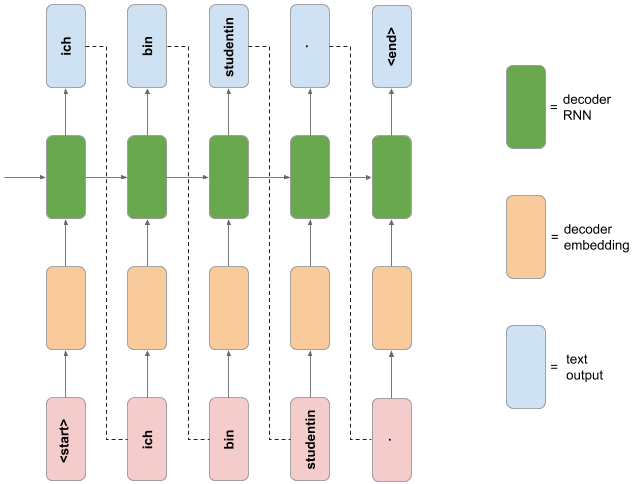

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

In [ ]:
unique_tokens = len(tokenizer.word_index) + 1

In [ ]:
class DecoderModel(Model):
  def __init__(self,initial_state=True,**kwargs):
    super(DecoderModel, self).__init__(**kwargs)
    self.embedding = Embedding(input_dim = unique_tokens,output_dim = 128,mask_zero = True)
    self.lstm = LSTM(512, return_sequences=True, return_state=True)
    self.dense = Dense(unique_tokens)
    self.initial_state = initial_state

  def call(self,inputs,hidden_state = None,cell_state = None):
    h = self.embedding(inputs)
    if hidden_state != None and cell_state != None:
      lstm,hidden_1,cell_1 = self.lstm(h,initial_state = [hidden_state,cell_state])
    else:
      lstm,hidden_1,cell_1 = self.lstm(h)
    h = self.dense(lstm)
    return h,hidden_1,cell_1

In [ ]:
decoder_model = DecoderModel()

In [ ]:
for english,german in train_dataset.take(1):
  temp,hidden_1,cell_1 = decoder_model(german)
print("decoder output shape:")
print(tf.shape(temp))
print("hidden state shape:")
print(tf.shape(hidden_1))
print("cell state shape:")
print(tf.shape(cell_1))

decoder output shape:
tf.Tensor([  16   14 5744], shape=(3,), dtype=int32)
hidden state shape:
tf.Tensor([ 16 512], shape=(2,), dtype=int32)
cell state shape:
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


In [ ]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop

In [ ]:
def german_io(german_data):
  
  input_data = german_data[:,0:tf.shape(german_data)[1]-1]
  output_data = german_data[:,1:tf.shape(german_data)[1]]
  return(input_data,output_data)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
@tf.function
def fb_passes(english_input,german_input,german_output):
  with tf.GradientTape() as tape:
    hidden_state ,cell_state = encoder_model(english_input)
    dense_output, _, _ = decoder_model(german_input, hidden_state, cell_state)
    loss = tf.math.reduce_mean(loss_object(german_output,dense_output))
    trainable_variables = encoder_model.trainable_variables + decoder_model.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
  return loss, gradients

In [ ]:
train_loss_results = []
val_loss_results = []

for epoch in tqdm(range(10)):
  
  epoch_loss = 0
  batch_no = 0
  with tqdm(total= 1000) as t:
    for english,german in train_dataset:
      german_input, german_output = german_io(german)
      loss, gradients = fb_passes(english, german_input, german_output)
      epoch_loss += loss
      batch_no += 1
      optimizer.apply_gradients(zip(gradients, encoder_model.trainable_variables + decoder_model.trainable_variables))
      epoch_avg_loss = epoch_loss / batch_no
      train_loss_results.append(epoch_avg_loss)
      t.update(1)
  epoch_val_loss = 0
  val_batch_no = 0
  with tqdm(total= 250) as t:
    for val_english,val_german in valid_dataset:
      german_input, german_output = german_io(val_german)
      loss, _ = fb_passes(val_english, german_input, german_output)
      epoch_val_loss += loss
      val_batch_no += 1
      epoch_avg_val_loss = epoch_val_loss / val_batch_no
      val_loss_results.append(epoch_avg_val_loss)
      t.update(1)
  print("Epoch {:02d}: Avg. training loss = {:.6f}, Avg. validation loss = {:.6f} ".format(epoch + 1,epoch_avg_loss,epoch_avg_val_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 01: Avg. training loss = 5.498888, Avg. validation loss = 4.861554 



Epoch 02: Avg. training loss = 4.355422, Avg. validation loss = 4.013315 



Epoch 03: Avg. training loss = 3.474457, Avg. validation loss = 3.298160 



Epoch 04: Avg. training loss = 2.664515, Avg. validation loss = 2.629859 



Epoch 05: Avg. training loss = 1.924626, Avg. validation loss = 2.045330 



Epoch 06: Avg. training loss = 1.303226, Avg. validation loss = 1.603017 



Epoch 07: Avg. training loss = 0.861156, Avg. validation loss = 1.338695 



Epoch 08: Avg. training loss = 0.593092, Avg. validation loss = 1.210045 



Epoch 09: Avg. training loss = 0.433946, Avg. validation loss = 1.163943 



Epoch 10: Avg. training loss = 0.332766, Avg. validation loss = 1.141235 



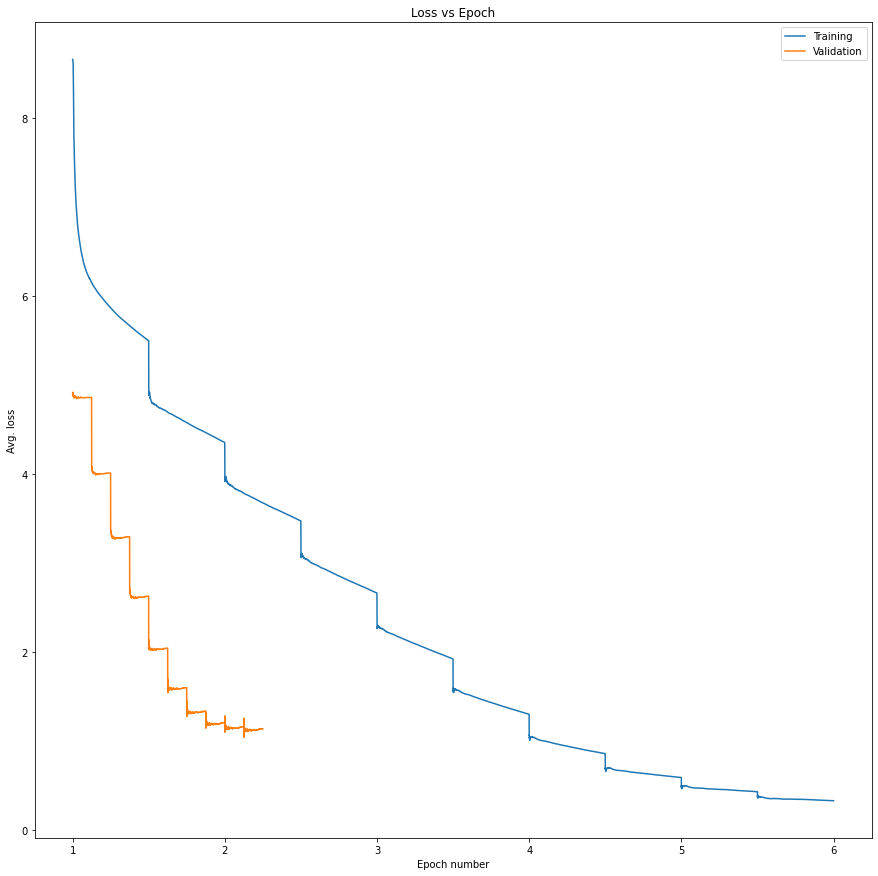

In [ ]:
epoch_range = range(0,10)

# The graph is inconsistent due to smaller data used to make training faster
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
ax.plot(train_loss_results, label="Training")
ax.plot(val_loss_results, label="Validation")
ax.legend(loc='best')
ax.set_title("Loss vs Epoch")
ax.set_xticklabels(epoch_range)
ax.set_xlabel("Epoch number")
ax.set_ylabel("Avg. loss") 

fig.show()

## 7. Use the model to translate

In [ ]:
random_ind = np.random.choice(20000,5)
examples = []
for ind in random_ind:
  examples.append(data_examples[ind])
english_sentences = [sentence.split('\t')[0] for sentence in examples]
processed_english = []
for sentence in english_sentences:
    processed_english.append(preprocess_sentence(sentence))

In [ ]:
start = tokenizer.word_index['<start>']
end = tokenizer.word_index['<end>']
examples_tokens = []
for p_english in processed_english:
  english = tf.strings.split(p_english,sep = " ")
  english = embedding_layer(english)
  english = tf.pad(english, [[13-len(english), 0], [0, 0]], constant_values = 0)
  english = tf.expand_dims(english, 0)
  hidden_state, cell_state = encoder_model(english)
  translated_tokens = []
  tf_token = tf.Variable([[start]])
  while True:
    output_1,hidden_state, cell_state = decoder_model(tf_token, hidden_state, cell_state)
    output_2 = tf.argmax(output_1, 2).numpy()[0,0]
    tf_token = tf.Variable([[output_2]])
    if output_2 == end:
      break
    else:
      translated_tokens.append(output_2)
  examples_tokens.append(translated_tokens)

In [ ]:
inv_german_index = {value:key for key,value in tokenizer.word_index.items()}
german_sentences = []
for example_token in examples_tokens:
  output_words = []
  for token in example_token:
    output_words.append(inv_german_index[token])
  output = " ".join(output_words)
  german_sentences.append(output)

In [ ]:
table = PrettyTable(['English sentences', 'German Translations'])
for english,german in zip(english_sentences,german_sentences):
  table.add_row([english,german])
  
print(table)

+--------------------+--------------------------------+
| English sentences  |      German Translations       |
+--------------------+--------------------------------+
| Even my mom knows. | meine leute hat dir gebissen . |
|  Tom seems eager.  | tom scheint unsicher zu sein . |
|  School is over.   |      die schule ist an .       |
|  Tom is a blond.   |   tom ist ein verrueckter .    |
| Tom is conceited.  |    tom ist ruecksichtslos .    |
+--------------------+--------------------------------+
